In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [13]:
import pprint
import glob
from pathlib import Path
import pickle
import random

import torch
from PIL import Image
import numpy as np
from pytorch3d.renderer import (
    look_at_view_transform
)
import matplotlib.pyplot as plt
import trimesh

import postprocess_dataset
from utils import utils
from evaluation import compute_iou_2d, compute_iou_2d_given_pose, compute_iou_3d, compute_chamfer_L1

In [4]:
# displays meshes at the predicted pose
def show_meshes(cfg, device, saved_model_path, gt_shapes_dict, only_show_instances=[], num_novel_view=3, compute_metrics=True, print_info=True):
    input_dir_img = cfg['dataset']['input_dir_img']
    input_dir_mesh = cfg['dataset']['input_dir_mesh']
    output_dir = "{}_{}".format(input_dir_mesh, exp_name)
    
    # combining all cached predicted poses
    cached_pred_poses = {}
    pred_pose_paths = list(Path(output_dir).rglob('pred_poses.p'))
    for pred_pose_path in pred_pose_paths:
        curr_cache = pickle.load(open(pred_pose_path, "rb"))
        cached_pred_poses = {**cached_pred_poses, **curr_cache}
    
    # getting paths of all processed meshes, keyed by instance name
    processed_paths = list(Path(saved_model_path).rglob('*.obj'))
    processed_paths_dict = {}
    for path in processed_paths:
        instance_name = str(path).split('/')[-1][:-4]
        if instance_name not in processed_paths_dict:
            processed_paths_dict[instance_name] = [path]
        else:
            processed_paths_dict[instance_name].append(path)
    
    for instance_name in processed_paths_dict:
        if len(only_show_instances) == 0 or instance_name in only_show_instances:
            for processed_mesh_path in processed_paths_dict[instance_name]:
            
                input_image = Image.open(os.path.join(input_dir_img, instance_name+".png"))
                # loading trimesh and pytorch3d meshes for the g.t., originally reconstructed, and refined model
                original_mesh_path = os.path.join(input_dir_mesh, instance_name+".obj")
                with torch.no_grad():
                    mesh_original = utils.load_untextured_mesh(original_mesh_path, device)
                    mesh_processed = utils.load_untextured_mesh(processed_mesh_path, device)
                mesh_original_trimesh = trimesh.load(original_mesh_path)
                mesh_processed_trimesh = trimesh.load(processed_mesh_path)
                
                # rendering gt, original, and processed mesh at predicted pose
                pred_dist = cached_pred_poses[instance_name]['dist']
                pred_elev = cached_pred_poses[instance_name]['elev']
                pred_azim = cached_pred_poses[instance_name]['azim']
                R, T = look_at_view_transform(pred_dist, pred_elev, pred_azim)
                mesh_original_render = utils.render_mesh(mesh_original, R, T, device)
                mesh_processed_render = utils.render_mesh(mesh_processed, R, T, device)
                
                # rendering processed mesh at poses other than the predicted pose
                novel_view_renders = []
                for i in range(num_novel_view):
                    R, T = look_at_view_transform(pred_dist, pred_elev, pred_azim+ ((i+1)*45))
                    novel_view_renders.append(utils.render_mesh(mesh_processed, R, T, device))
                
                # computing performance metrics before refinement
                if compute_metrics:
                    gt_mesh_path = gt_shapes_dict[instance_name]
                    with torch.no_grad():
                        mesh_gt = utils.load_untextured_mesh(gt_mesh_path, device)
                    mesh_gt_trimesh = trimesh.load(gt_mesh_path)
                    
                    mesh_gt_render = utils.render_mesh(mesh_gt, R, T, device)
                    
                    #iou_2d_before = compute_iou_2d(mesh_original, input_image, device)
                    iou_2d_before = compute_iou_2d_given_pose(mesh_original, input_image, device, pred_azim, pred_elev, pred_dist)
                    iou_3d_before = compute_iou_3d(mesh_original_trimesh, mesh_original, mesh_gt_trimesh, mesh_gt)
                    chamfer_before = compute_chamfer_L1(mesh_original_trimesh, mesh_original, mesh_gt_trimesh, mesh_gt)
                    # computing metrics after refinement
                    #iou_2d_after = compute_iou_2d(mesh_processed, input_image, device)
                    # TODO: not sure if using the original pred pose for the processed iou is legitimate
                    iou_2d_after = compute_iou_2d_given_pose(mesh_processed, input_image, device, pred_azim, pred_elev, pred_dist)
                    iou_3d_after = compute_iou_3d(mesh_processed_trimesh, mesh_processed, mesh_gt_trimesh, mesh_gt)
                    chamfer_after = compute_chamfer_L1(mesh_processed_trimesh, mesh_processed, mesh_gt_trimesh, mesh_gt)
                    num_columns = 4+num_novel_view
                else:
                    iou_2d_before = 0
                    iou_3d_before = 0
                    chamfer_before = 0
                    iou_2d_after = 0
                    iou_3d_after = 0
                    chamfer_after = 0
                    num_columns = 3+num_novel_view

                # visualizing
                if print_info:
                    print(processed_mesh_path)
                    print("Metrics before refinement -- 2d IoU: {}, 3d IoU: {}, Chamfer dist: {}".format(iou_2d_before, iou_3d_before, chamfer_before))
                    print("Metrics after refinement -- 2d IoU: {}, 3d IoU: {}, Chamfer dist: {}".format(iou_2d_after, iou_3d_after, chamfer_after))
                
                fig, ax = plt.subplots(nrows=1, ncols=num_columns, squeeze=False, figsize=(15,5))
                col_i = 0
                ax[0][col_i].imshow(input_image)
                ax[0][col_i].xaxis.set_visible(False)
                ax[0][col_i].yaxis.set_visible(False)
                
                if compute_metrics:
                    col_i += 1
                    ax[0][col_i].imshow(mesh_gt_render[0, ..., :3].cpu().numpy())
                    ax[0][col_i].xaxis.set_visible(False)
                    ax[0][col_i].yaxis.set_visible(False)      

                col_i += 1
                ax[0][col_i].imshow(mesh_original_render[0, ..., :3].cpu().numpy())
                ax[0][col_i].xaxis.set_visible(False)
                ax[0][col_i].yaxis.set_visible(False)

                col_i += 1
                ax[0][col_i].imshow(mesh_processed_render[0, ..., :3].cpu().numpy())
                ax[0][col_i].xaxis.set_visible(False)
                ax[0][col_i].yaxis.set_visible(False)
                
                col_i += 1
                for i in range(num_novel_view):
                    ax[0][col_i+i].imshow(novel_view_renders[i][0, ..., :3].cpu().numpy())
                    ax[0][col_i+i].xaxis.set_visible(False)
                    ax[0][col_i+i].yaxis.set_visible(False)
                plt.pause(0.05)

In [8]:
cfg_path = "configs/refine.yaml"
exp_name = "processed"
gt_shapes_path = "/home/svcl-oowl/brandon/research/sil_consistent_at_inference/data_evaluation/pix3d_chair/pix3d_chair_gt_shapes.lst"


cfg = utils.load_config(cfg_path, "configs/default.yaml")
device = torch.device("cuda:0")
gt_shapes_dict = {}
with open(gt_shapes_path, 'r') as f:
    f = f.read().split('\n')
    for line in f:
        if line != "":
            gt_shapes_dict[line.split(" ")[0]] = line.split(" ")[1]
processed_model_path = cfg['dataset']['input_dir_mesh']+"_{}".format(exp_name)

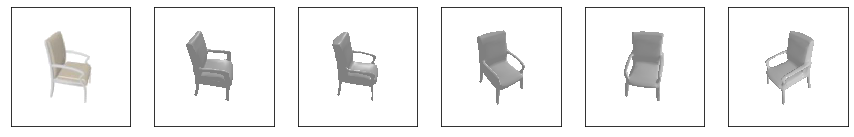

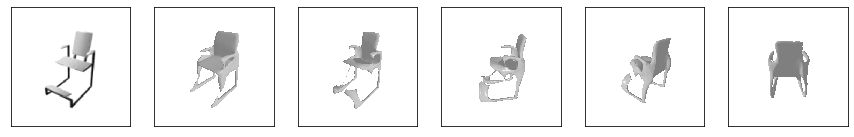

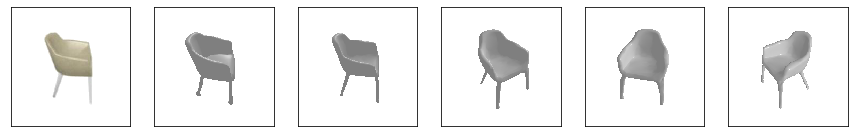

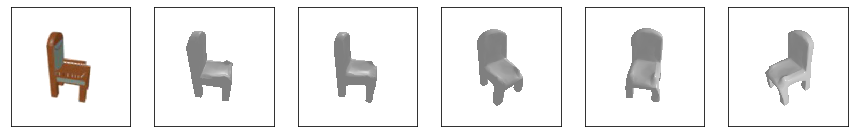

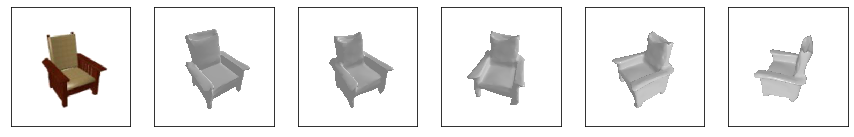

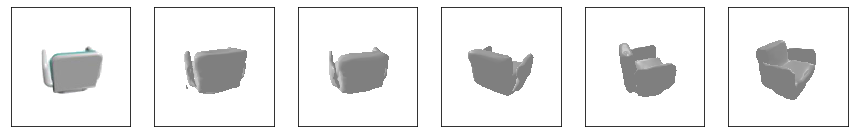

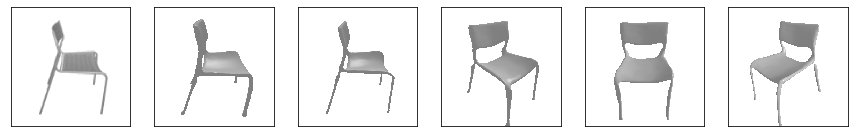

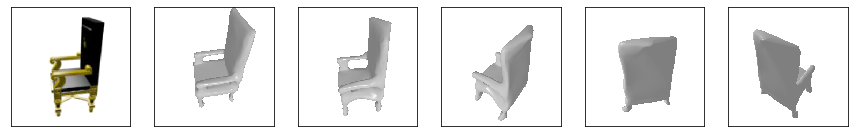

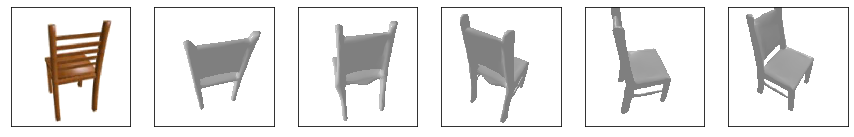

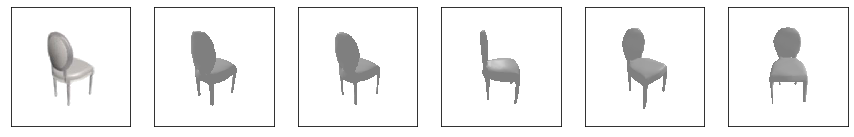

In [16]:
# show postprocessed meshes at predicted angle
instances = random.sample([str(path).split('/')[-1].replace('.obj',"") for path in list(Path(processed_model_path).rglob('*.obj'))], 10)

show_meshes(cfg, device, processed_model_path, gt_shapes_dict, only_show_instances=instances, compute_metrics=False, print_info=False)

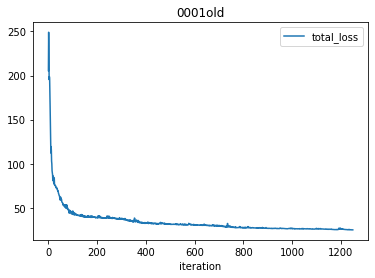

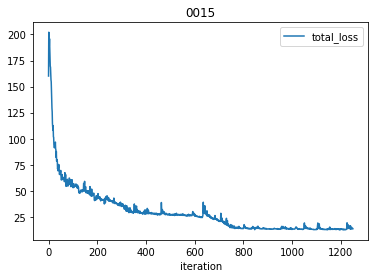

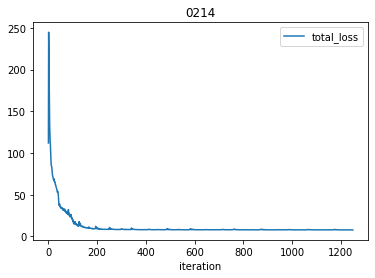

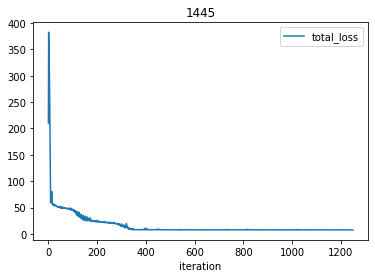

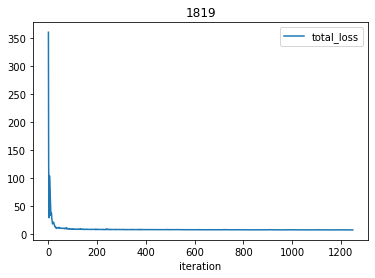

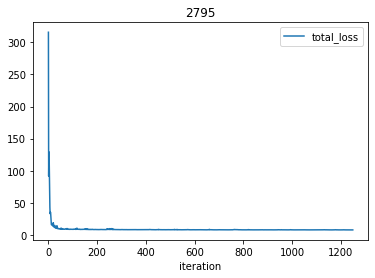

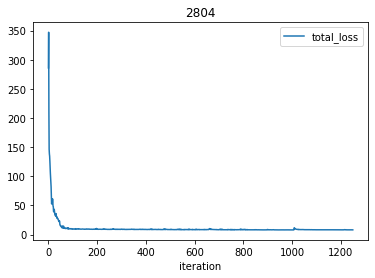

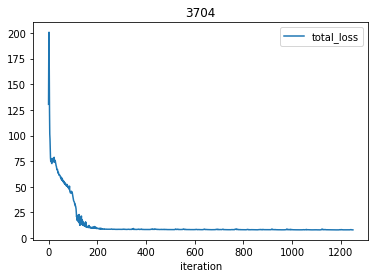

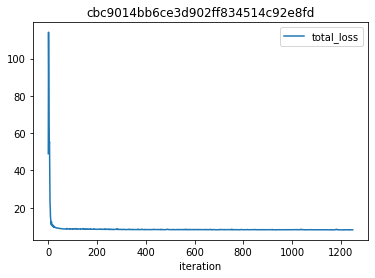

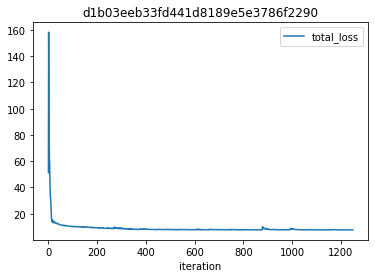

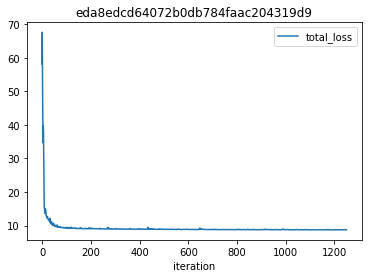

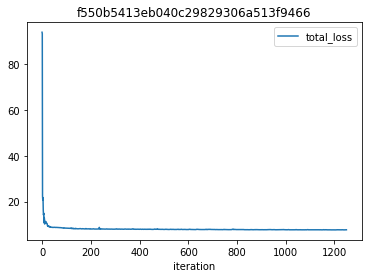

In [28]:
# show training loss info
# getting paths of all loss info pickled files
input_dir_mesh = cfg['dataset']['input_dir_mesh']
output_dir = "{}_{}".format(input_dir_mesh, exp_name)
cached_loss_info_paths = list(Path(output_dir).rglob('loss_info.p'))

for path in cached_loss_info_paths:
    dataset_loss_info = pickle.load(open(path, "rb"))
    for instance_name in dataset_loss_info:
        loss_info = dataset_loss_info[instance_name]
        loss_info.plot.line(x='iteration', y='total_loss', title="{}".format(instance_name))
        #loss_info.plot.line(x='iteration', y='sil_loss')
        #loss_info.plot.line(x='iteration', y='img_sym_loss')
        #loss_info.plot.line(x='iteration', y='vertex_sym_loss')
        #loss_info.plot.line(x='iteration', y='l2_loss')
        #loss_info.plot.line(x='iteration', y='lap_smoothness_loss')
        #loss_info.plot.line(x='iteration', y='normal_consistency_loss')
        #loss_info.plot.line(x='iteration', y='semantic_dis_loss')